# Project 3

### Business Problem
The St. Joseph public health department/clinic wants to help improve the overall health of the county's residents. Through the progression of pandemic, people's lifestyles have changed drastically with a general decrease in overall physical activity. Since the decrease in physical activity could lead to obesity, health officials are looking to see how much of the well-known factors that are associated with obesity can affect a person's obesity level. 

Veggies: 1: Never, 2: Sometimes, 3: Always<br>
H2O: 1: Less than 1L, 2: Less than 2L, 3: More than 2L<br>
Physical Activity: 0: None, 1: 1-2 days, 2: 2-4 days, 3: 4-5 days<br>
Time on Devices: 0: None, 1: 2 hrs or less, 2: 3-5 hrs, 3: 5+hrs<br>

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

from sklearn import metrics
from sklearn import tree, svm
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.svm import SVC

from scipy.spatial.distance import euclidean
from scipy import stats

pd.set_option('display.max_columns', None)

## Data Cleaning and Preparation

In [129]:
obesity=pd.read_csv('data/ObesityDataSet_raw_and_data_sinthetic.csv', header=0)
obesity.head()

,Gender,Age,Height,Weight,Family_Obesity_History,Frequent_HighCalorie_Food,Veggies,Num_of_Meals,Food_btw_Meals,Smoke,H2O,Calorie_Monitor,Physical_Activity,Time_On_Devices,Alcohol_Consump,Transportation,Obesity_Level
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


The data itself did not have any missing values, so it was unneccessary to drop any of them initially

In [130]:
print(len(obesity))
obesity.isna().sum()

2111


Gender                       0
Age                          0
Height                       0
Weight                       0
Family_Obesity_History       0
Frequent_HighCalorie_Food    0
Veggies                      0
Num_of_Meals                 0
Food_btw_Meals               0
Smoke                        0
H2O                          0
Calorie_Monitor              0
Physical_Activity            0
Time_On_Devices              0
Alcohol_Consump              0
Transportation               0
Obesity_Level                0
dtype: int64

In [131]:
obesity.nunique()

Gender                          2
Age                          1402
Height                       1574
Weight                       1525
Family_Obesity_History          2
Frequent_HighCalorie_Food       2
Veggies                       810
Num_of_Meals                  635
Food_btw_Meals                  4
Smoke                           2
H2O                          1268
Calorie_Monitor                 2
Physical_Activity            1190
Time_On_Devices              1129
Alcohol_Consump                 4
Transportation                  5
Obesity_Level                   7
dtype: int64

In [132]:
obesity['Age']=obesity['Age'].astype('float')

In [133]:
obesity.head()

,Gender,Age,Height,Weight,Family_Obesity_History,Frequent_HighCalorie_Food,Veggies,Num_of_Meals,Food_btw_Meals,Smoke,H2O,Calorie_Monitor,Physical_Activity,Time_On_Devices,Alcohol_Consump,Transportation,Obesity_Level
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Before doing the train test split, I had to clean some of the categorical variables and the numerical varaibles. Because the dataset description had stated that variables such as Veggies, Num_of_Meals, H20, etc were categorical, I had to round the float numbers so that it represented the correct category. After the floats were rounded, I noticed that only one person had an alcohol consumption level of always. Because he was the only one who had such alcohol consumption level, I deemed it as an outlier and dropped it. This was also necessary because only one of either the test or training data set would contain this person, and therefore, the number of columns after one hot encoding would be different from each other.

In [134]:
# while it is a better practice to adjust the data after train test split, I am only rounding these numerical values
# because 1. it only changes the values to a whole number or other integers that fit the data description
# 2. because it would be the same if the data were changed after train test splitting, but would just be additional
# lines of unneccessary code
obesity['Age']=round(obesity['Age'],1)
obesity['Height']=round(obesity['Height'],2)
obesity['Weight']=round(obesity['Weight'],1)
obesity['Veggies']=round(obesity['Veggies'],0)
obesity['Num_of_Meals']=round(obesity['Num_of_Meals'],0)
obesity['H2O']=round(obesity['H2O'],0)
obesity['Physical_Activity']=round(obesity['Physical_Activity'],0)
obesity['Time_On_Devices']=round(obesity['Time_On_Devices'],0)

In [135]:
# Here I am dropping a single row that had an 'Always' on Alcohol_Consump because there was only 1
# person from the entire data. This later threw off X_train and X_test because there was only 1 person
# that always drank alcohol; therefore, could not compare the two splits
obesity.loc[obesity['Alcohol_Consump']=="Always"]
obesity=obesity.drop(labels=26)

In [136]:
obesity['Obesity_Level'].value_counts()

zObesity_Type_I        351
zObesity_Type_III      324
zObesity_Type_II       297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          286
Insufficient_Weight    272
Name: Obesity_Level, dtype: int64

In [137]:
# obesity.loc[obesity['Obesity_Level']=='Insufficient_Weight' ]='Normal_Weight' 
# obesity.loc[obesity['Obesity_Level']=='Overweight_Level_I' ]='Normal_Weight' 
# obesity.loc[obesity['Obesity_Level']=='Overweight_Level_II' ]='Obese' 
# obesity.loc[obesity['Obesity_Level']=='Overweight_Level_I' ]='Obese' 
# obesity.loc[obesity['Obesity_Level']=='Overweight_Level_I' ]='Obese' 
# obesity.loc[obesity['Obesity_Level']=='Overweight_Level_I' ]='Obese' 

After the initial data prepping, train test split was performed

In [138]:
weight_dict={'Insufficient_Weight': 'Normal_Weight',
             'Overweight_Level_I': 'Overweight', 
             'Normal_Weight': 'Normal_Weight',
             'Overweight_Level_II': 'Overweight', 
             'zObesity_Type_I': 'Obese', 
             'zObesity_Type_II': 'Obese', 
             'zObesity_Type_III': 'Obese'}

weight_dict

{'Insufficient_Weight': 'Normal_Weight',
 'Overweight_Level_I': 'Overweight',
 'Normal_Weight': 'Normal_Weight',
 'Overweight_Level_II': 'Overweight',
 'zObesity_Type_I': 'Obese',
 'zObesity_Type_II': 'Obese',
 'zObesity_Type_III': 'Obese'}

In [139]:
obesity['Obesity_Level']=obesity['Obesity_Level'].replace(weight_dict)
obesity['Obesity_Level'].value_counts()

Obese            972
Overweight       580
Normal_Weight    558
Name: Obesity_Level, dtype: int64

In [140]:
cat_dict={'Normal_Weight':0,
         'Overweight': 1,
         'Obese': 2}


In [141]:
#Train test split
X=obesity.drop(columns=['Obesity_Level', 'Weight','Height'])
y=obesity['Obesity_Level'].map(cat_dict)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)
y_train.value_counts(normalize=True)

2    0.466486
1    0.274204
0    0.259309
Name: Obesity_Level, dtype: float64

In order to only encode the categorical variables, column names were specified, and since the dependent(outcome) variables were also categorical, they were label encoded.

In [142]:
# One hot encoder
# instead of using the actual one hot encoder, I've decided to use get_dummies because three(now one) 
# of the columns are not categorical
columns= ['Gender', 'Family_Obesity_History','Frequent_HighCalorie_Food','Veggies','Num_of_Meals',
                        'Food_btw_Meals','Smoke','H2O','Calorie_Monitor','Physical_Activity','Time_On_Devices',
                        'Alcohol_Consump','Transportation']
X_train_ohe =pd.get_dummies(X_train, columns= columns, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, columns= columns, drop_first=True)
print(X_test_ohe.columns)
# print(X_train_ohe.columns)

Index(['Age', 'Gender_Male', 'Family_Obesity_History_yes',
       'Frequent_HighCalorie_Food_yes', 'Veggies_2.0', 'Veggies_3.0',
       'Num_of_Meals_2.0', 'Num_of_Meals_3.0', 'Num_of_Meals_4.0',
       'Food_btw_Meals_Frequently', 'Food_btw_Meals_Sometimes',
       'Food_btw_Meals_no', 'Smoke_yes', 'H2O_2.0', 'H2O_3.0',
       'Calorie_Monitor_yes', 'Physical_Activity_1.0', 'Physical_Activity_2.0',
       'Physical_Activity_3.0', 'Time_On_Devices_1.0', 'Time_On_Devices_2.0',
       'Alcohol_Consump_Sometimes', 'Alcohol_Consump_no',
       'Transportation_Bike', 'Transportation_Motorbike',
       'Transportation_Public_Transportation', 'Transportation_Walking'],
      dtype='object')


In [143]:
#Label Encoder for y. Fit transforming so that it is in array form
# le=LabelEncoder()
# y_train_le =le.fit_transform(y_train)
# y_test_le = le.transform(y_test)
# le.inverse_transform(np.unique(y_train_le))#.value_counts(1)
# reduce overall number of columns to less than 4 combine not drop

## Decision Tree

The first type of modeling that I used was the decision tree.

In [144]:
dtree=DecisionTreeClassifier()
dtree.fit(X_train_ohe, y_train)

DecisionTreeClassifier()

In [145]:
# y_hat_train = dtree.predict(X_train_ohe)
# y_hat_test = dtree.predict(X_test_ohe)

# print(metrics.classification_report(y_test, y_hat_test))
# fig, ax= plt.subplots(figsize=(6,6))
# metrics.plot_confusion_matrix(dtree, X_test_ohe, y_test_le, cmap='Blues', normalize='true', 
#                              display_labels=list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6])), ax=ax)
# plt.xticks(rotation=45)
# print(f'Training Score: {round(dtree.score(X_train_ohe, y_train_le), 2)}')
# print(f'Test Score: {round(dtree.score(X_test_ohe, y_test_le), 2)}')


In [146]:
# label=list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6]))
label=list(cat_dict.keys())
def model_score(model,X_train, X_test, y_train, y_test, label=None ):
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    print(metrics.classification_report(y_test, y_hat_test, target_names=label))
    fig, ax= plt.subplots(figsize=(6,6))
    metrics.plot_confusion_matrix(model, X_test, y_test, cmap='Blues', normalize='true', 
                                 display_labels= label, ax=ax)
#     plt.xticks(rotation=45)
    print(f'Training Score: {round(model.score(X_train, y_train), 2)}')
    print(f'Test Score: {round(model.score(X_test, y_test), 2)}')


               precision    recall  f1-score   support

Normal_Weight       0.76      0.79      0.77       175
   Overweight       0.70      0.60      0.65       175
        Obese       0.83      0.88      0.85       283

     accuracy                           0.78       633
    macro avg       0.76      0.76      0.76       633
 weighted avg       0.77      0.78      0.78       633

Training Score: 1.0
Test Score: 0.78


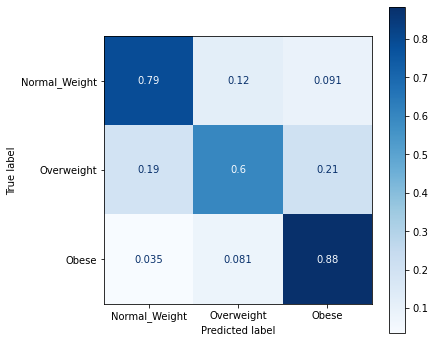

In [147]:
model_score(dtree, X_train_ohe, X_test_ohe, y_train, y_test, label=label)

<AxesSubplot:>

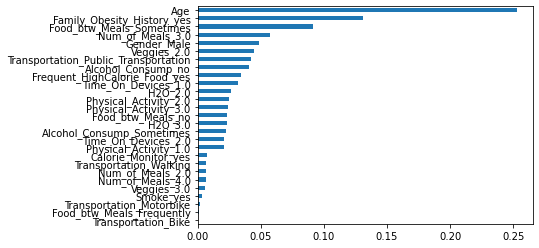

In [148]:
importances=pd.Series(dtree.feature_importances_, index=X_train_ohe.columns)
importances.sort_values(ascending=True).plot(kind='barh')

#do this for logi regress

In [149]:
def get_coef(model, X, i=0):
    df=pd.DataFrame()
    coef= pd.Series(model.coef_[i:i+1].flatten(), index=X.columns)#, name=f'Series{i,i+1}')
    coef['intercept']= model.intercept_[0]
    return coef

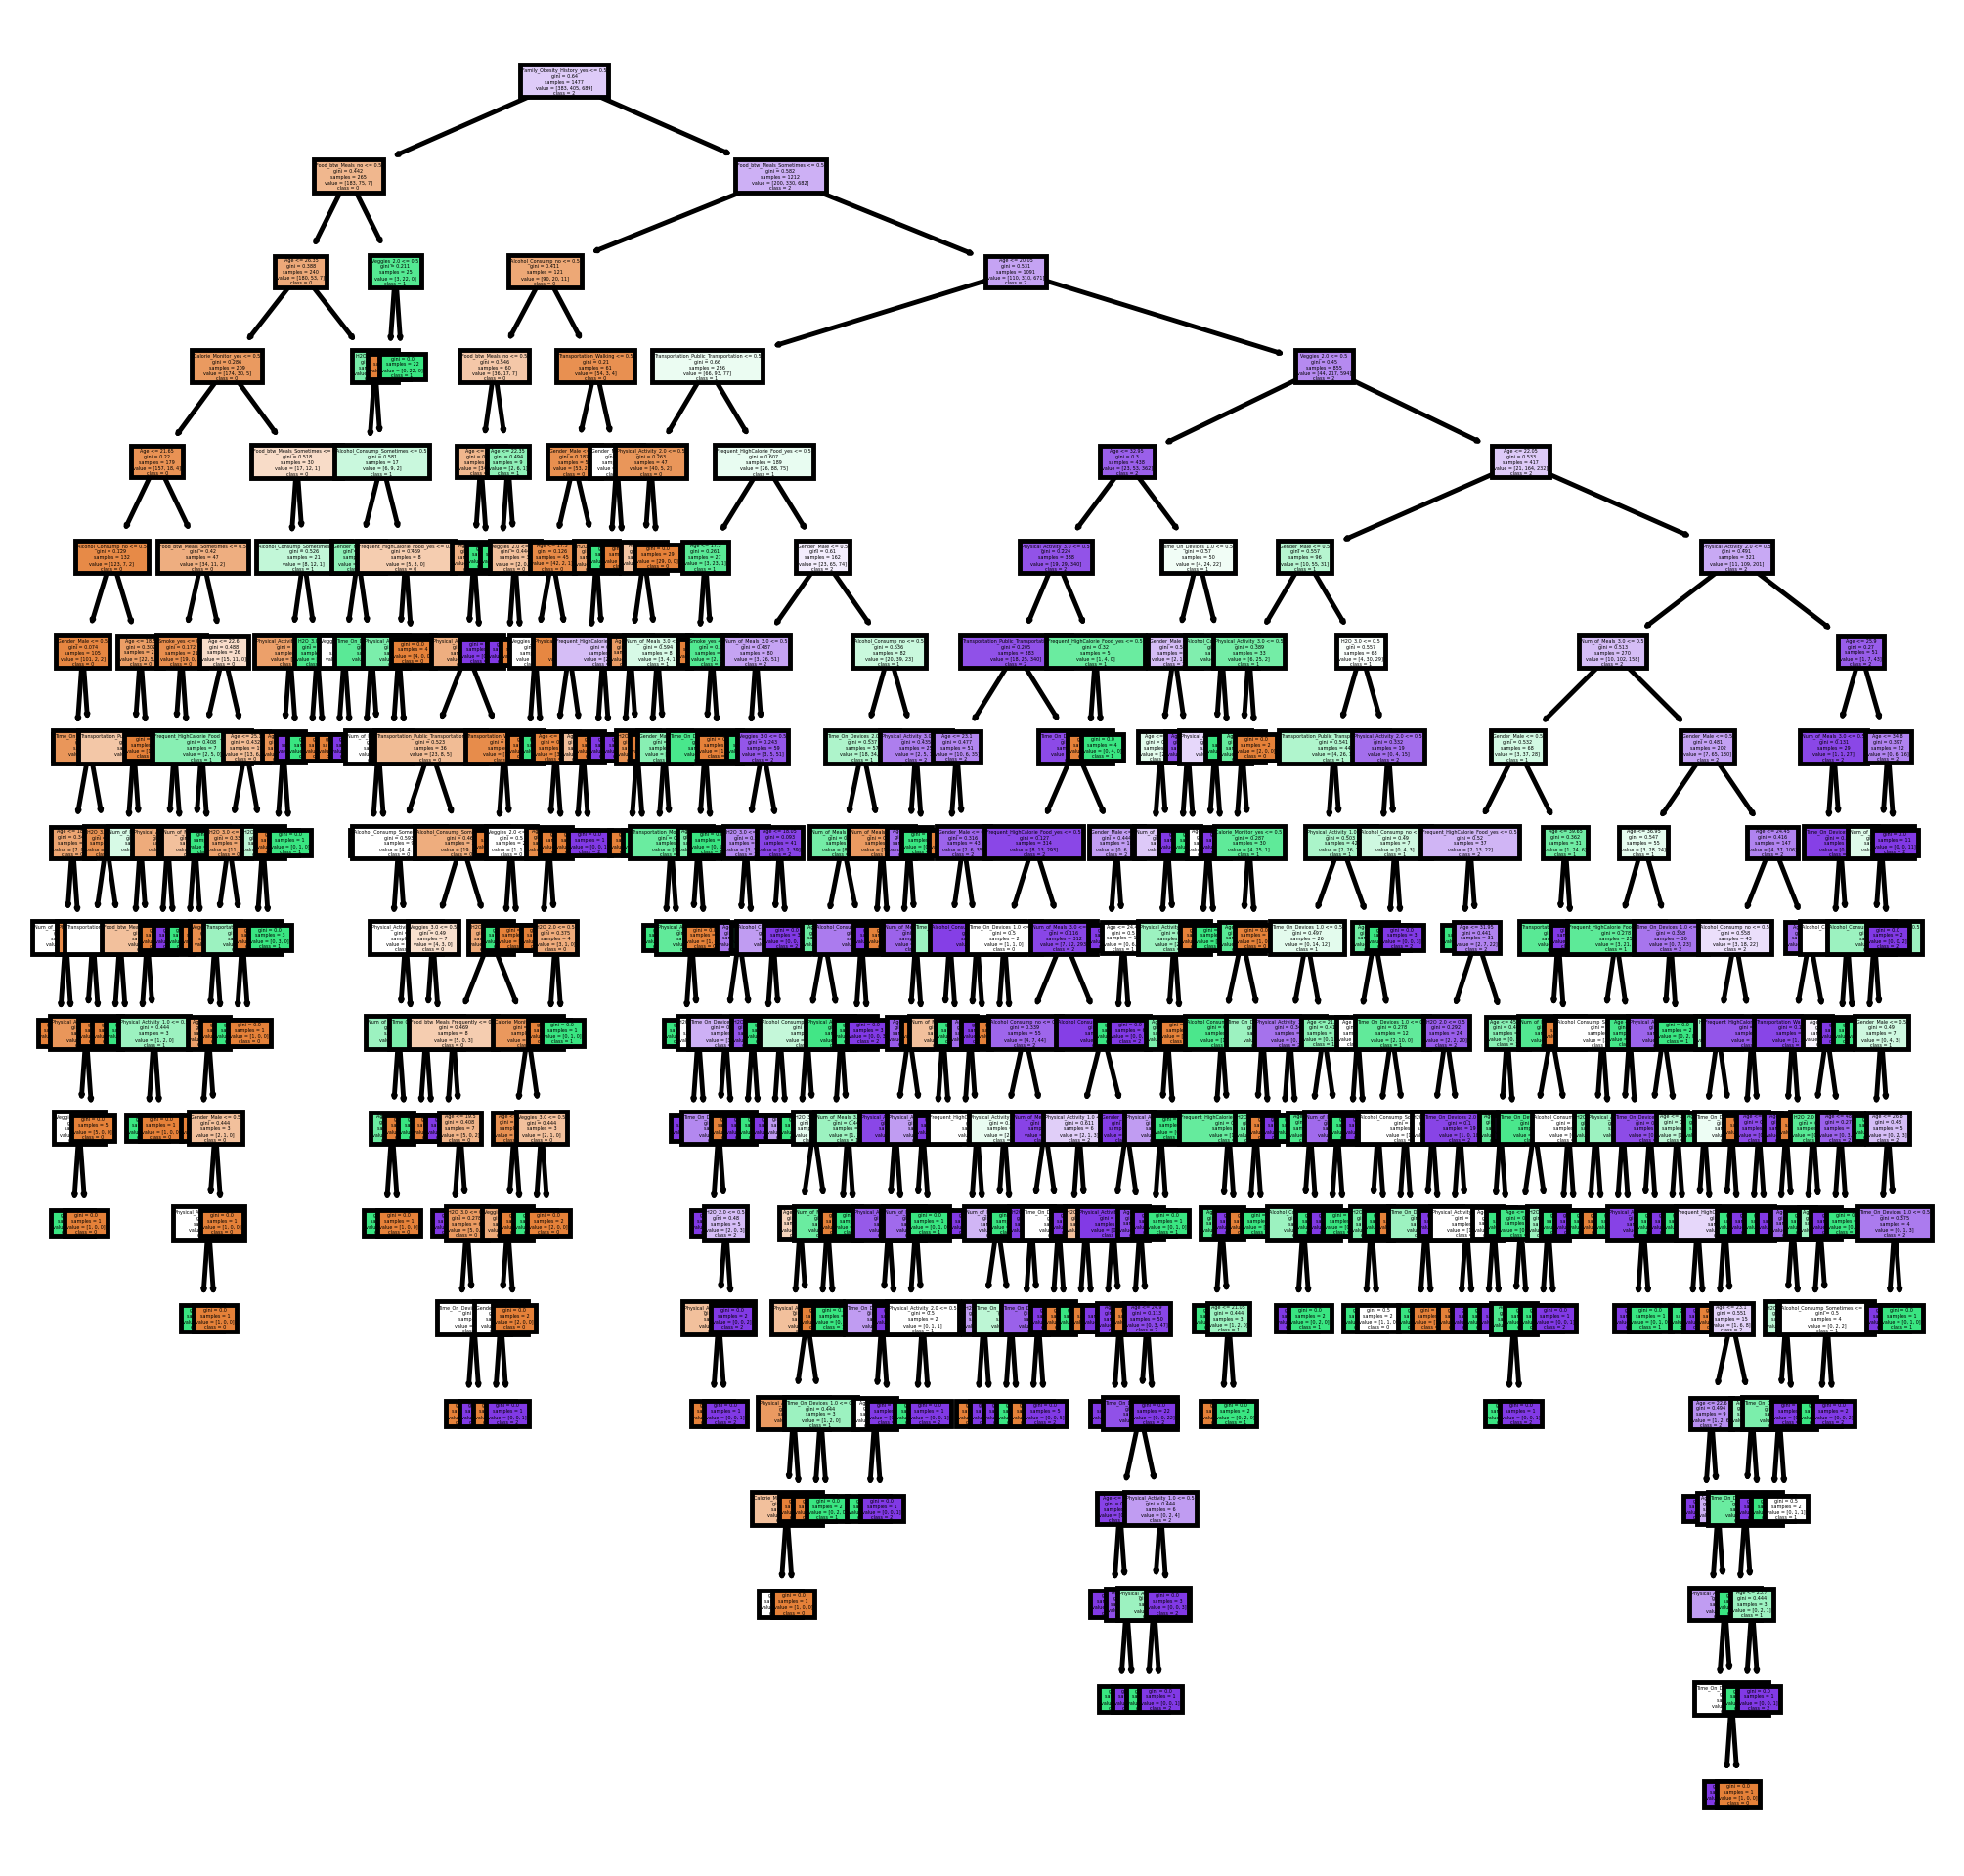

In [150]:
fig=plt.subplots(nrows=1, ncols=1, figsize=(7, 7), dpi=350)
tree_plot=tree.plot_tree(dtree, feature_names=X_train_ohe.columns, class_names=np.unique(y_train).astype('str'), filled=True)
plt.show()
# find accuracy/precision of this

### Grid Search CV

In order to find which parameters were best for the decision tree above. Here we see that a criterion of entropy, max_depth of 11, and min samples leaf and split of 1 and 2 respectively are the best parameters for the Decision Tree.

In [151]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [15, 16, 17, 18, 19],
    'min_samples_split': [1, 2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

gs_tree = GridSearchCV(dtree, param_grid, cv=3)
gs_tree.fit(X_train_ohe, y_train)

gs_tree.best_params_

#make the model AGAIN using these criterions to show these are actually better 

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [152]:
dtree2=DecisionTreeClassifier(criterion='entropy',max_depth= 15,min_samples_leaf= 1,min_samples_split= 3)
dtree2.fit(X_train_ohe, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=3)

               precision    recall  f1-score   support

Normal_Weight       0.77      0.82      0.80       175
   Overweight       0.69      0.63      0.66       175
        Obese       0.84      0.84      0.84       283

     accuracy                           0.78       633
    macro avg       0.77      0.77      0.77       633
 weighted avg       0.78      0.78      0.78       633

Training Score: 0.98
Test Score: 0.78


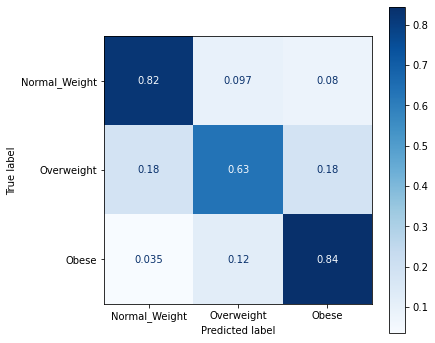

In [153]:
model_score(dtree2, X_train_ohe, X_test_ohe, y_train, y_test, label=label)

<AxesSubplot:>

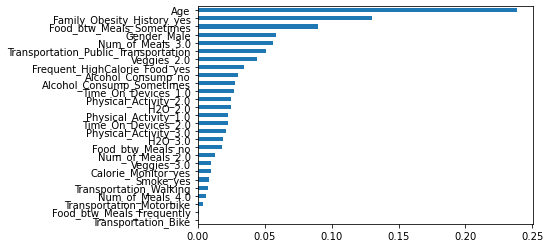

In [154]:
importances2=pd.Series(dtree2.feature_importances_, index=X_train_ohe.columns)
importances2.sort_values(ascending=True).plot(kind='barh')

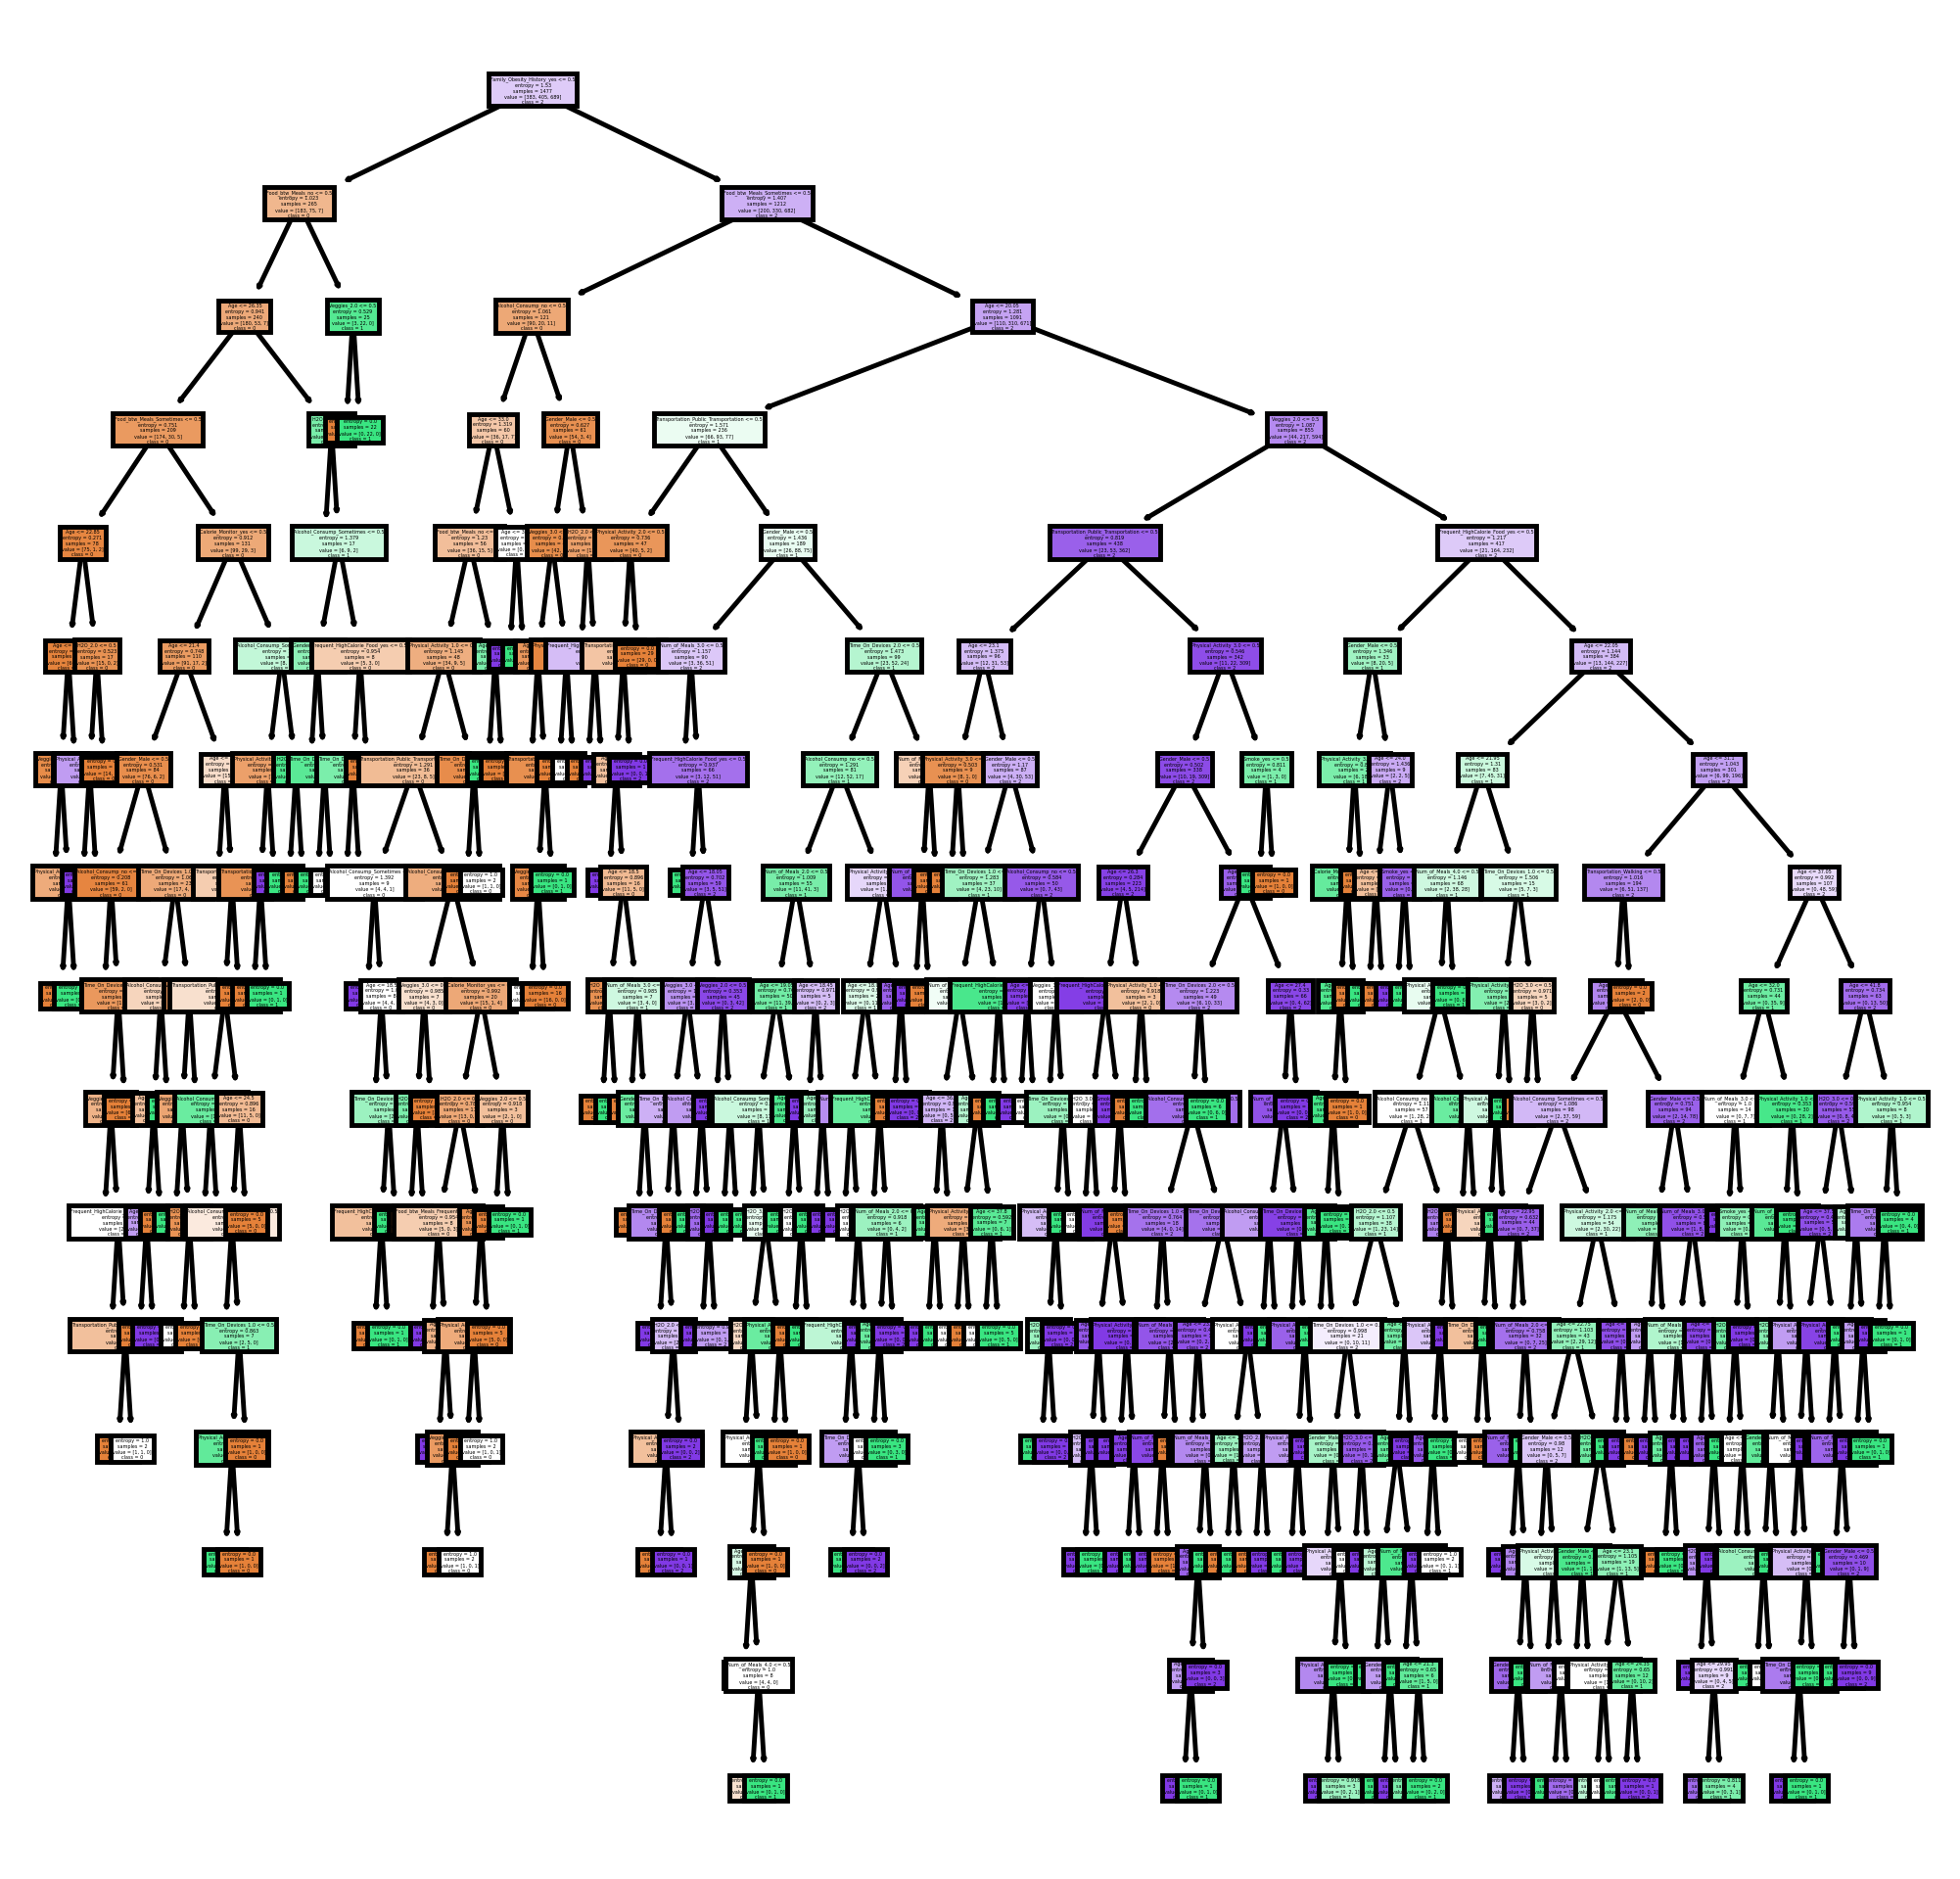

In [155]:
fig2=plt.subplots(nrows=1, ncols=1, figsize=(7, 7), dpi=350)
tree_plot=tree.plot_tree(dtree2, feature_names=X_train_ohe.columns, class_names=np.unique(y_train).astype('str'), filled=True)
plt.show()

In [156]:
param_grid2 = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [ 13, 14, 15, 16, 17],
    'min_samples_split': [1, 2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

gs_tree2 = GridSearchCV(dtree2, param_grid2, cv=3)
gs_tree2.fit(X_train_ohe, y_train)

gs_tree2.best_params_

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 898, in fit
    super().fit(
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fi

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.76505494 0.7630183  0.7603124         nan 0.7603124
 0.76301555 0.76166466        nan 0.76369581 0.76098715 0.76233942
        nan 0.76436782 0.76436644 0.76436644        nan 0.76233667
 0.76165916 0.76165916        nan 0.77790971 0.76707922 0.76234766
        nan 0.76301693 0.76233942 0.76099128        nan 0.76572833
 0.76572833 0.76369443        nan 0.76165779 0.7623353  0.76233667
        nan 0.76436782 0.7630128  0.76369168        nan 0.76910487
 0.76708334 0.76031652        nan 0.76572695 0.75624323 0.7603124
        nan 0.76030415 0.75827575 0.76233804        nan 0.76098028
 0.76098166 0.76233667        nan 0.76368894 0.76436782 0.76030415
        nan 0.77181902 0.77385016 0.76911311        nan 0.76572558
 0.75353458 0.76302242        nan 0.76166329 0.76165916 0.76708059
        nan 0.76030278 0.75962389 0.7630128         

{'criterion': 'gini',
 'max_depth': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [157]:
dtree3=DecisionTreeClassifier(criterion='gini',max_depth= 14,min_samples_leaf= 1,min_samples_split= 2)
dtree3.fit(X_train_ohe, y_train)

DecisionTreeClassifier(max_depth=14)

               precision    recall  f1-score   support

Normal_Weight       0.75      0.78      0.76       175
   Overweight       0.69      0.61      0.64       175
        Obese       0.83      0.88      0.85       283

     accuracy                           0.77       633
    macro avg       0.76      0.75      0.75       633
 weighted avg       0.77      0.77      0.77       633

Training Score: 0.99
Test Score: 0.77


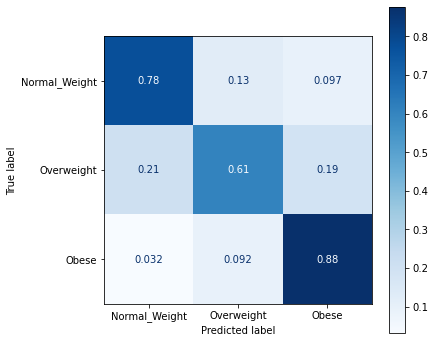

In [158]:
model_score(dtree3, X_train_ohe, X_test_ohe, y_train, y_test, label=label)

<AxesSubplot:>

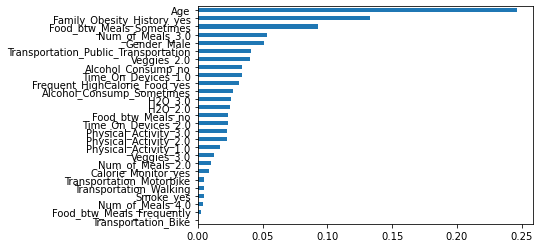

In [159]:
importances3=pd.Series(dtree3.feature_importances_, index=X_train_ohe.columns)
importances3.sort_values(ascending=True).plot(kind='barh')

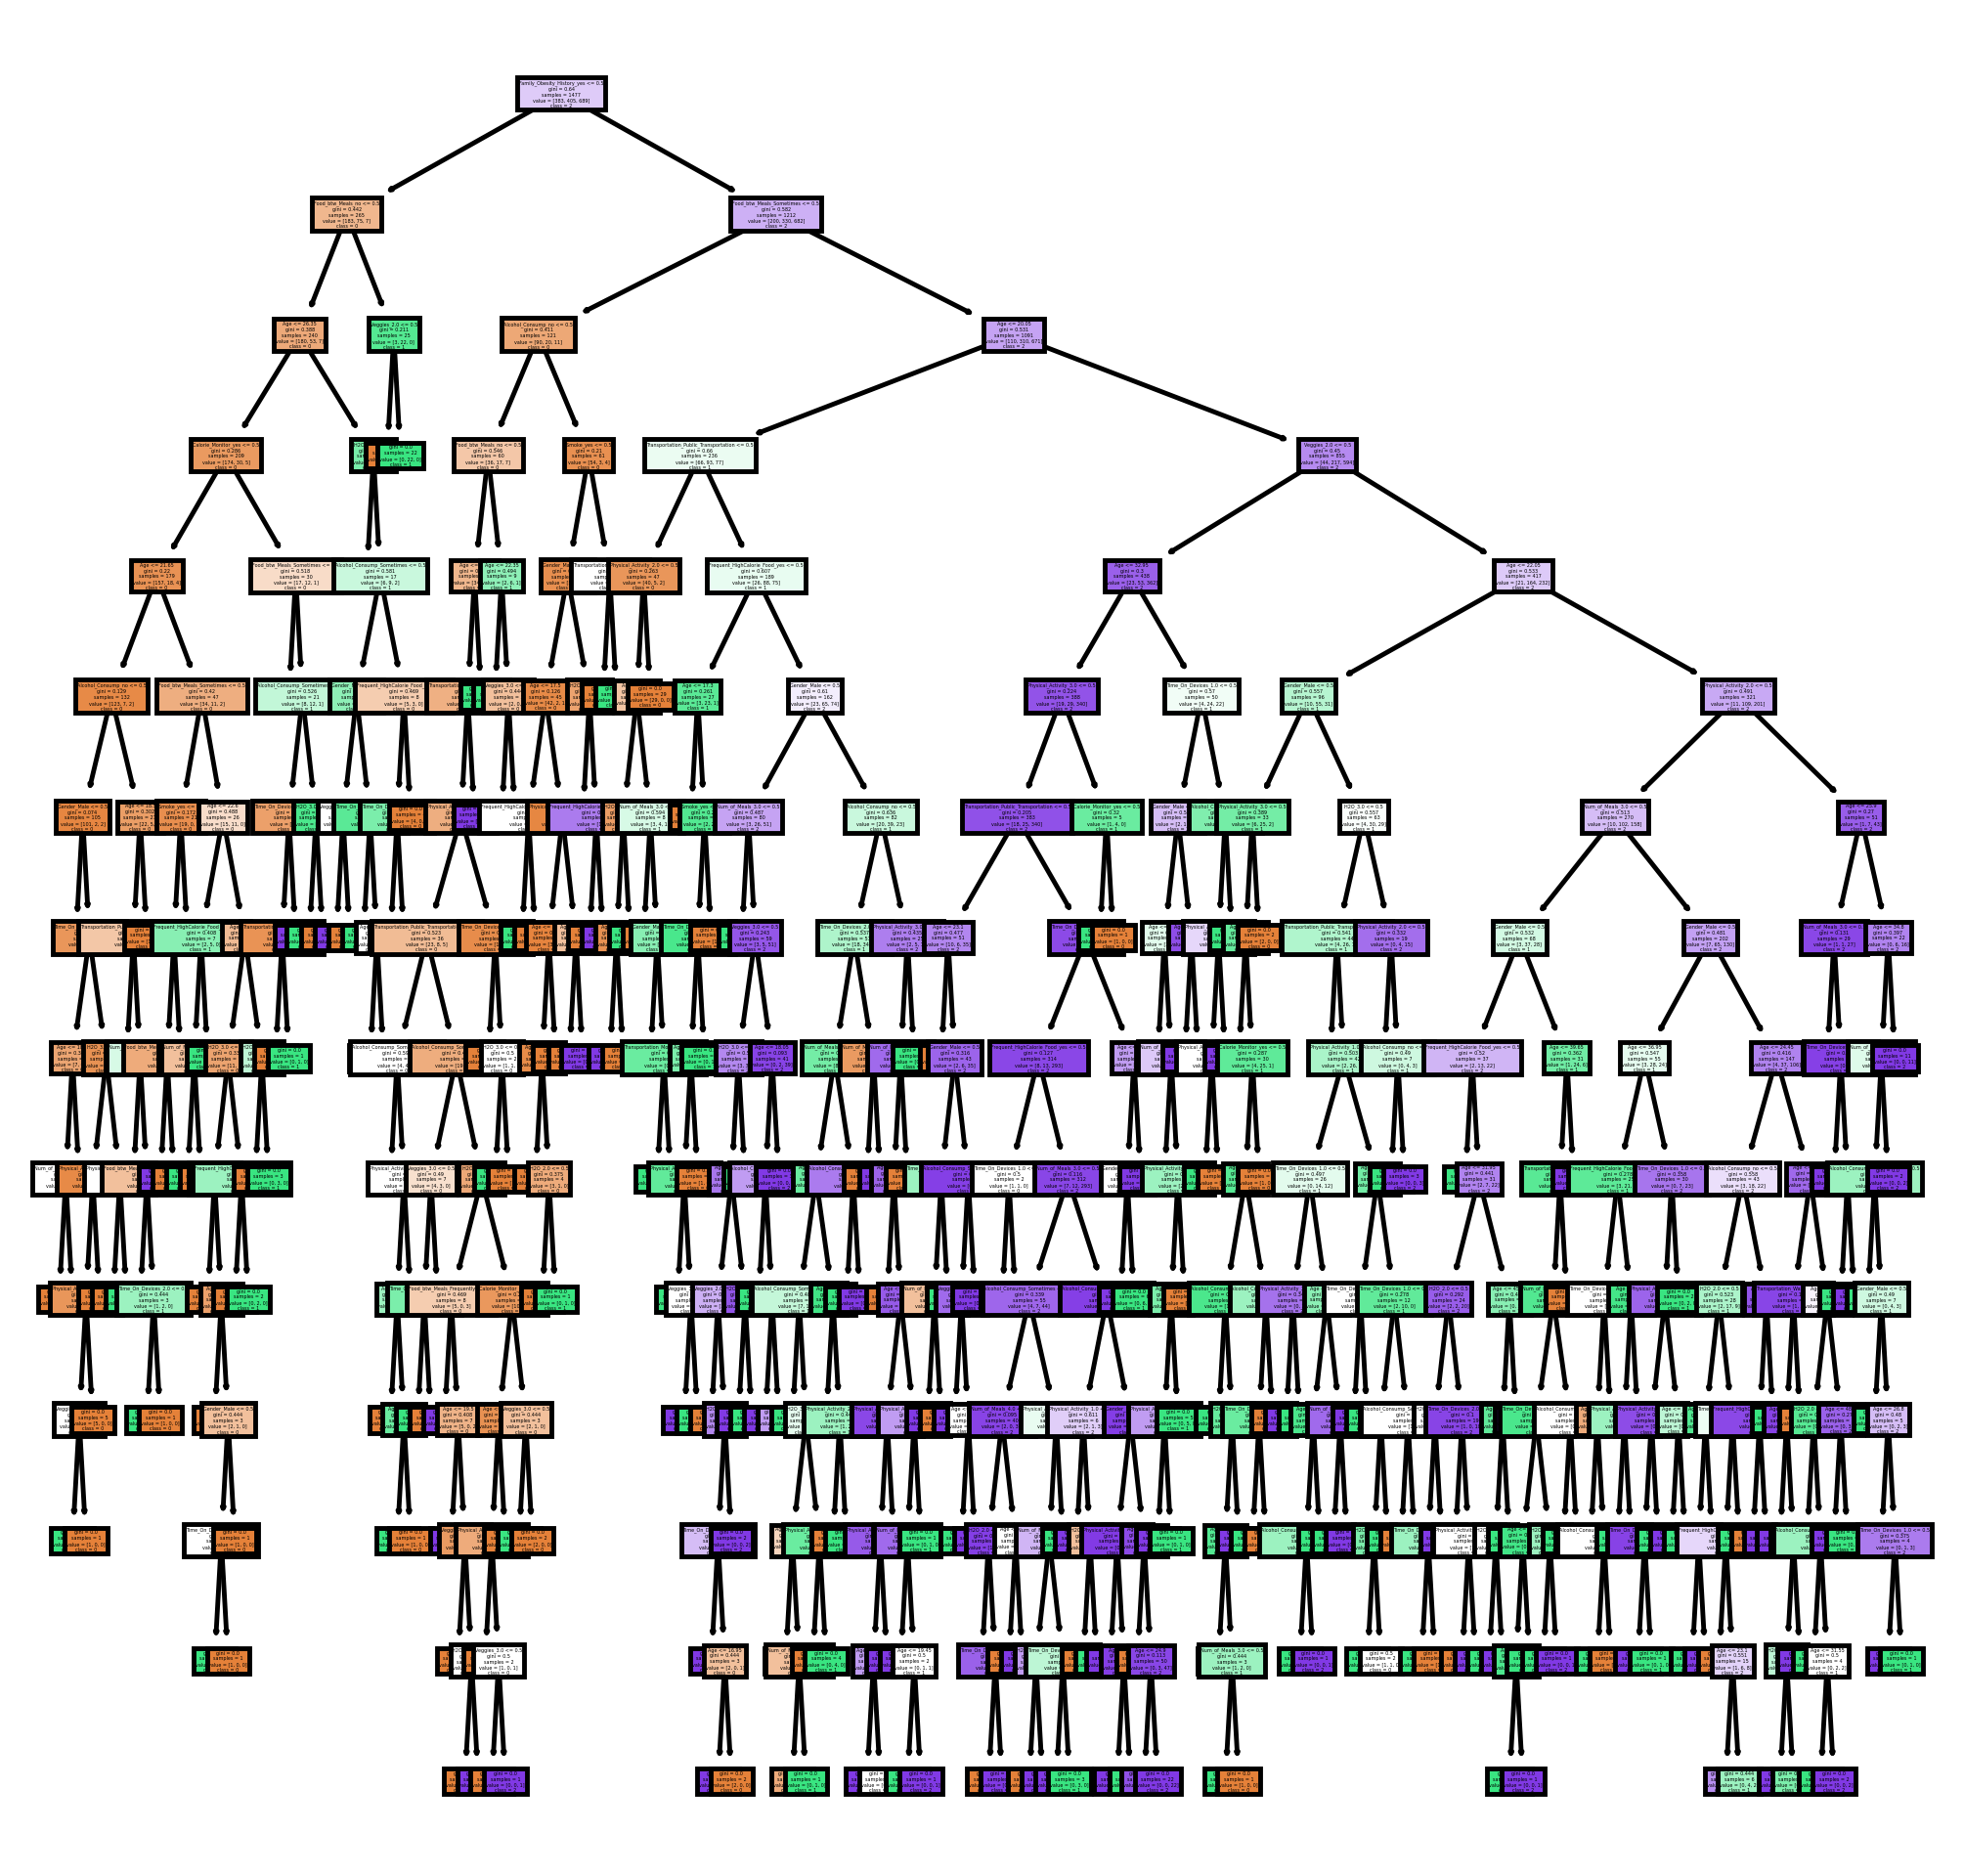

In [160]:
fig3=plt.subplots(nrows=1, ncols=1, figsize=(7, 7), dpi=350)
tree_plot=tree.plot_tree(dtree3, feature_names=X_train_ohe.columns, class_names=np.unique(y_train).astype('str'), filled=True)
plt.show()

### Standard Scaler

In order to use the K nearest neighbors classifier and logistic regression, the numerical variables had to be scaled down. To avoid having the categorical variables scaled as well, column names are specified

In [161]:
#Standard Scaler
scaler=StandardScaler()
cols=['Age']
# columns that need to be scaled are labeled so that categorical data isn't scaled as well
# for i in cols:
scale = scaler.fit(X_train_ohe[cols])
# scale inversetransform to get data back


# transform the training data columns
X_train_ohe[cols] = scale.transform(X_train_ohe[cols])
# transform the testing data columns
X_test_ohe[cols] = scale.transform(X_test_ohe[cols])

## K-Nearest-Neighbors

Using the KNN classifier, we are able to determine the accuracy scores of our model. We can observe that as the weight level becomes more normal, the accuracy of our predictions become lower, and as we go towards the extremes of the weight level, our predictions become much more accurate. 

               precision    recall  f1-score   support

Normal_Weight       0.82      0.72      0.77       175
   Overweight       0.66      0.53      0.58       175
        Obese       0.75      0.90      0.82       283

     accuracy                           0.75       633
    macro avg       0.74      0.72      0.72       633
 weighted avg       0.75      0.75      0.74       633

Training Score: 0.84
Test Score: 0.75


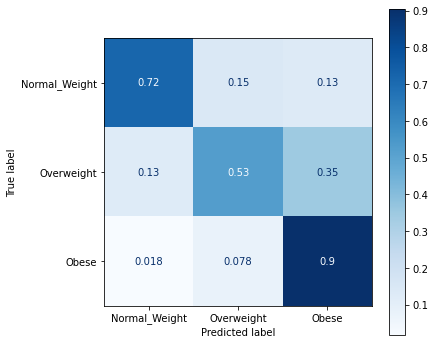

In [162]:
# K Nearest Neighbors
knn=KNeighborsClassifier()
knn.fit(X_train_ohe, y_train)
# pred= knn.predict(X_test_ohe)
# instead of finding out the individual scores, I used the classification report from the metrics
# to find all scores
model_score(knn, X_train_ohe, X_test_ohe, y_train, y_test, label=label)
#show classification report for all models

### Grid Search

In [182]:
param_grid_knn = {
    'n_neighbors': list(range(1,38, 2)),#[3, 5, 7, 13, 19, 25, 37],
    'weights': ['uniform', 'distance'],
    'metric':['minkowski','euclidean',' manhattan']
}

gs_knn = GridSearchCV(knn, param_grid_knn)#, scoring='f1')
gs_knn.fit(X_train_ohe, y_train)

gs_knn.best_params_

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric ' manhattan' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric ' manhattan' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric ' manhattan' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can

{'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}

               precision    recall  f1-score   support

Normal_Weight       0.81      0.73      0.77       175
   Overweight       0.75      0.67      0.71       175
        Obese       0.81      0.92      0.86       283

     accuracy                           0.80       633
    macro avg       0.79      0.77      0.78       633
 weighted avg       0.79      0.80      0.79       633

Training Score: 1.0
Test Score: 0.8


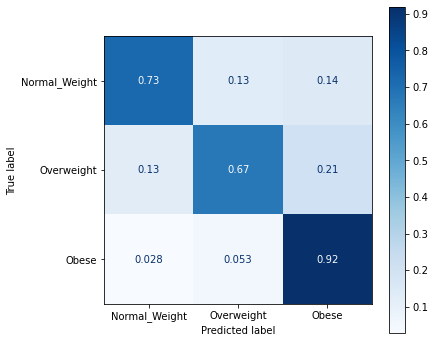

In [179]:
knn_gs=KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn_gs.fit(X_train_ohe, y_train)
model_score(knn_gs, X_train_ohe, X_test_ohe, y_train, y_test, label=label)

In [ ]:
# Because y columns were label encoded, this is to show which number corresponds to
# individual obesity levels
# list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6]))


#max dictionaries match(?)

### Normalization

Even after our data had been scaled, logistic regression requires that our variables be between 0 and 1. Because of this, we have to normalize our data by subtracting the smallest value of the variable from the current variable and dividing the difference by the largest value of the variable minus the smallest value of the variable.

In [82]:
# normalization
# use MINMAX scaler not this
# refer to standardscaler 

# X_train_norm= X_train_ohe.copy()
# X_test_norm = X_test_ohe.copy()

# for i in X_train_norm.columns:
#     X_train_norm[i] = (X_train_norm[i] - min(X_train_norm[i]))/ (max(X_train_norm[i]) - min(X_train_norm[i]))
#     X_test_norm[i] = (X_test_norm[i] - min(X_test_norm[i]))/ (max(X_test_norm[i]) - min(X_test_norm[i]))
minmaxer=MinMaxScaler()
cols=['Age']
minmax=minmaxer.fit(X_train_ohe[cols])#reshape(1,-1))
X_train_ohe[cols] = minmax.transform(X_train_ohe[cols])#.values.flatten())#reshape(1,-1))
X_test_ohe[cols] = minmax.transform(X_test_ohe[cols])#.values.flatten())#reshape(1,-1))


## Logistic Regression



               precision    recall  f1-score   support

Normal_Weight       0.78      0.75      0.76       175
   Overweight       0.53      0.31      0.39       175
        Obese       0.69      0.89      0.78       283

     accuracy                           0.69       633
    macro avg       0.67      0.65      0.64       633
 weighted avg       0.67      0.69      0.67       633

Training Score: 0.73
Test Score: 0.69


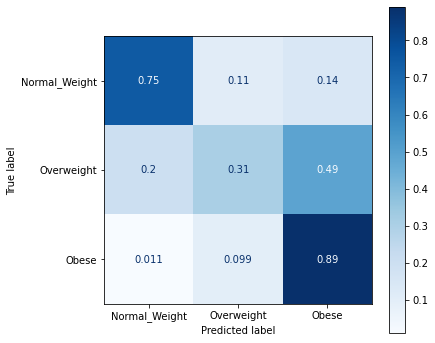

In [83]:
# logistic regression
log = LogisticRegression(C=1e9, solver='saga', multi_class='multinomial')
log.fit(X_train_ohe, y_train)
model_score(log, X_train_ohe, X_test_ohe, y_train, y_test, label=label)
# log_model=log.fit(X_train_norm, y_train_le)
# log_model

In [47]:
log.coef_.shape
# coef= pd.Series(model.coef_[i:i+1].flatten(), index=X.columns)
#     coef['intercept']= model.intercept_[0]

(3, 27)

<AxesSubplot:>

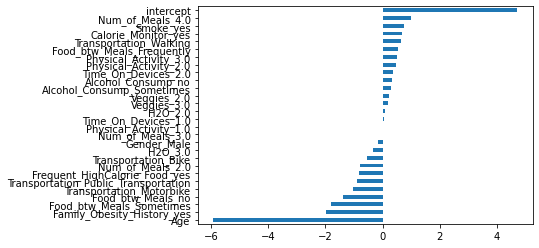

In [89]:
# regression coefficients
# since each obesity level had to be compared with the level below it to see how each
# independent variables affect them, 'i' was added 

coef0 = get_coef(log, X_train_ohe, 0)
coef1 = get_coef(log, X_train_ohe, 1)
coef2 = get_coef(log, X_train_ohe, 2)


coef0.sort_values(ascending=True).plot(kind='barh')
# importances2=pd.Series(dtree2.feature_importances_, index=X_train_ohe.columns)
# importances2.sort_values(ascending=True).plot(kind='barh')
# log.coef_[6]

<AxesSubplot:>

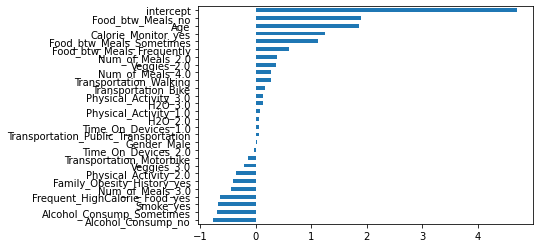

In [90]:
coef1.sort_values(ascending=True).plot(kind='barh')

<AxesSubplot:>

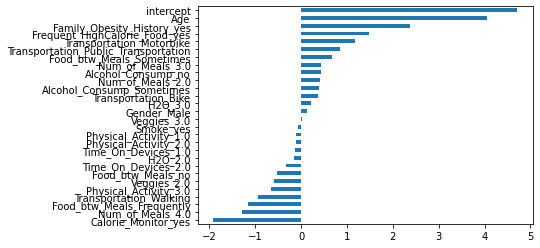

In [91]:
coef2.sort_values(ascending=True).plot(kind='barh')

In [ ]:
# prediction

# y_hat_train = log.predict(X_train_norm)
# y_hat_test = log.predict(X_test_norm)

# # looking at the residuals for training data :correct 90.2%
# resi = np.abs(y_train_le - y_hat_train)
# print(f'Training Score: {log.score(X_train_norm, y_train_le)}')
# print(pd.Series(resi).value_counts())
# print(pd.Series(resi).value_counts(normalize=True))


In [ ]:
# residuals for test data correct: 82.9%
# resi_test = np.abs(y_test_le - y_hat_test)
# print(f'Training Score: {log.score(X_test_norm, y_test_le)}')
# print(pd.Series(resi_test).value_counts())
# print(pd.Series(resi_test).value_counts(normalize=True))


In [ ]:
# obesity2=obesity.copy()
# for i, y in enumerate(obesity2):
#     if y.startswith('z'):
#         obesity2['Obese'][i]=1

# y_obese_train=pd.DataFrame([[0,0]]*len(y_train),columns=['Not_Obese', 'Obese'])
# for i, y in enumerate(y_train):
#     if y.startswith('z'):
#         y_obese_train['Obese'][i]=1
#     else:
#         y_obese_train['Not_Obese'][i]=1

# y_obese_test=pd.DataFrame([[0,0]]*len(y_test),columns=[ 'Not_Obese','Obese'])
# for i, y in enumerate(y_test):
#     if y.startswith('z'):
#         y_obese_test['Obese'][i]=1
#     else:
#         y_obese_test['Not_Obese'][i]=1


# y_obese_train=pd.DataFrame([0]*len(y_train),columns=[ 'Obese'])
# for i, y in enumerate(y_train):
#     if y.startswith('z'):
#         y_obese_train['Obese'][i]=1
        

# y_obese_test=pd.DataFrame([0]*len(y_test),columns=[ 'Obese'])
# for i, y in enumerate(y_test):
#     if y.startswith('z'):
#         y_obese_test['Obese'][i]=1

# y_obese=y_obese_train.append(y_obese_test)


In [ ]:
# confusion matrix
# metrics.confusion_matrix(y_test, y_hat_test)
# fig, ax= plt.subplots(figsize=(6,6))
# metrics.plot_confusion_matrix(log, X_test_norm, y_test_le, cmap='Blues',
#                              display_labels=list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6])), ax=ax)
# plt.xticks(rotation=45)
# plt.show()

#our confusion matrix shows that it is much better at predicting the extremes of obesity level.
# insufficient weight , obesity type ii and obesity type iii were most accurately predicted
# as the obesity level nears the center, ie normal weight, overweight i, overweight ii, and obesity type i; 

# the accuracy decreases

In [49]:
X0=pd.Series(coef0, index=X_train_ohe.columns)
X1=pd.Series(coef1, index=X_train_ohe.columns)
X2=pd.Series(coef2, index=X_train_ohe.columns)
X0,X1,X2

(Age                                    -0.813892
 Gender_Male                            -0.151135
 Family_Obesity_History_yes             -1.971786
 Frequent_HighCalorie_Food_yes          -0.827797
 Veggies_2.0                             0.213507
 Veggies_3.0                             0.195800
 Num_of_Meals_2.0                       -0.791236
 Num_of_Meals_3.0                        0.016041
 Num_of_Meals_4.0                        1.010339
 Food_btw_Meals_Frequently               0.562745
 Food_btw_Meals_Sometimes               -1.796392
 Food_btw_Meals_no                      -1.371074
 Smoke_yes                               0.748631
 H2O_2.0                                 0.098221
 H2O_3.0                                -0.349798
 Calorie_Monitor_yes                     0.670668
 Physical_Activity_1.0                   0.026568
 Physical_Activity_2.0                   0.473192
 Physical_Activity_3.0                   0.517767
 Time_On_Devices_1.0                     0.066041


In [50]:
odds0=np.exp(coef0)
odds1=np.exp(coef1)
odds2=np.exp(coef2)


odds0, odds1, odds2

(Age                                      0.443130
 Gender_Male                              0.859732
 Family_Obesity_History_yes               0.139208
 Frequent_HighCalorie_Food_yes            0.437011
 Veggies_2.0                              1.238012
 Veggies_3.0                              1.216283
 Num_of_Meals_2.0                         0.453284
 Num_of_Meals_3.0                         1.016170
 Num_of_Meals_4.0                         2.746531
 Food_btw_Meals_Frequently                1.755484
 Food_btw_Meals_Sometimes                 0.165896
 Food_btw_Meals_no                        0.253834
 Smoke_yes                                2.114104
 H2O_2.0                                  1.103206
 H2O_3.0                                  0.704830
 Calorie_Monitor_yes                      1.955544
 Physical_Activity_1.0                    1.026924
 Physical_Activity_2.0                    1.605109
 Physical_Activity_3.0                    1.678277
 Time_On_Devices_1.0           

In [ ]:
# metrics.plot_roc_curve(log, X_test_norm, y_test_le)

In [52]:
X_norm=X_train_ohe.append(X_test_ohe)
np.array(X_norm).reshape(-1)


array([-0.33779668,  1.        ,  1.        , ...,  0.        ,
        1.        ,  0.        ])

In [ ]:
y_obese_train.values.reshape(1,-1)

In [ ]:
# X_train_norm=sm.add_constant(X_train_norm)
# X_train_norm.values.shape()
# X_norm=sm.add_constant(X_norm)
# X=sm.add_constant(X)
# logit=sm.Logit(np.array(y_obese_train.values.reshape(1,-1)), np.asarray(X_norm).reshape(-1,1))
# print(logit.fit().summary())

In [ ]:
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
# y_score = classifier.fit(X_train_norm, y_train_le).decision_function(X_test_norm)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_le[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# normalizing for scikit learn logistic regression
# creating a scaled version of the dataframe 
# obesity_scaled=pd.DataFrame(X_train_ohe.append(X_test_ohe), columns=X_train_ohe.columns).sort_index()
# obesity_scaled.head()

# normalization (while it isn't needed for the categorical variables as they are only 0s and 1s, but for age, height, weight)
# for i in obesity_scaled.columns:
#     obesity_scaled[i] = (obesity_scaled[i] - min(obesity_scaled[i]))/ (max(obesity_scaled[i]) - min(obesity_scaled[i]))
# obesity_scaled.head()